# Somatic vs non-somatic classification

**Goal:** first work on the classifier
  
This notebook is divided in two parts:
* **1. Bla**

In [1]:
%run ../setup_environment.ipy
%run ../Selene_Job.ipy

Setup environment... done!


<span style="color:green">✅ Working on **impact-annotator_env** conda environment.</span>

## Get the data and choose the model

In [2]:
data = Impact_Wrapper('../../../data/annotated_final_IMPACT_mutations_180508.txt', 'is_artefact')

In [40]:
from sklearn.model_selection import StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=10)

from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import GradientBoostingClassifier
model = make_pipeline(RandomUnderSampler(ratio='majority', random_state=42),
                      GradientBoostingClassifier(random_state=42, loss='deviance', max_depth=6, n_estimators=500))

In [46]:
features_groups = {
    'NGS': ['t_depth', 't_vaf', 't_alt_count',
            'n_depth', 'n_vaf', 'n_alt_count',
            't_ref_plus_count', 't_ref_neg_count', 't_alt_plus_count', 't_alt_neg_count',
            'sample_coverage'],

    'genome': ['Chromosome', 'VEP_SYMBOL', 'VEP_VARIANT_CLASS'],

    'freq': ['frequency_in_normals'],

    'database': ['VEP_COSMIC_CNT', 'VEP_in_dbSNP',
                 'is_a_hotspot', 'is_a_3d_hotspot', 'oncogenic'],

    'consequence': ['gene_type', 'VEP_Consequence', 'VEP_IMPACT', 'VEP_CLIN_SIG',
                    'VEP_SIFT_class', 'VEP_PolyPhen_class'],

    'AF': ['VEP_gnomAD_AF', 'VEP_gnomAD_total_AF_max', 'VEP_gnomAD_total_AF',
           'VEP_gnomAD_total_AF_AFR', 'VEP_gnomAD_total_AF_AMR', 'VEP_gnomAD_total_AF_ASJ', 'VEP_gnomAD_total_AF_EAS', 'VEP_gnomAD_total_AF_FIN', 'VEP_gnomAD_total_AF_NFE', 'VEP_gnomAD_total_AF_OTH',
           'Kaviar_AF'],
}

AF_populations = ['VEP_gnomAD_total_AF_AFR', 'VEP_gnomAD_total_AF_AMR', 'VEP_gnomAD_total_AF_ASJ', 'VEP_gnomAD_total_AF_EAS', 'VEP_gnomAD_total_AF_FIN', 'VEP_gnomAD_total_AF_NFE', 'VEP_gnomAD_total_AF_OTH']

    
def get_features(groups_to_remove = [], individual_features_to_remove=[]):

    final_selection = []
        
    for key, group in features_groups.items():
        if not key in groups_to_remove:
            final_selection += group
    
    final_selection = [f for f in final_selection if f not in individual_features_to_remove]
    
    # remove unique values
    return list(set(final_selection))

In [47]:
features = get_features(individual_features_to_remove = AF_populations + ['VEP_SYMBOL'])
data.process(features)

X, y = data.get_X_and_y('all', 'all')
Impact_Wrapper.print_info(X, y)

X: (194211, 84) | y: (194211,)


,count_,freq_
False,187012,96.3%
True,7199,3.7%


## All features

In [48]:
metrics_all = Metrics(model, X, y, cv_strategy, n_jobs=5, scoring=['accuracy', 'f1', 'roc_auc', 'average_precision', 'recall'])

Run model... done! (237.72s)


In [49]:
metrics_all.print_mean()

▴ Mean accuracy         : 0.881 ± 0.002
▴ Mean f1               : 0.329 ± 0.006
▴ Mean roc_auc          : 0.911 ± 0.006
▴ Mean average_precision: 0.605 ± 0.016
▴ Mean recall           : 0.786 ± 0.018


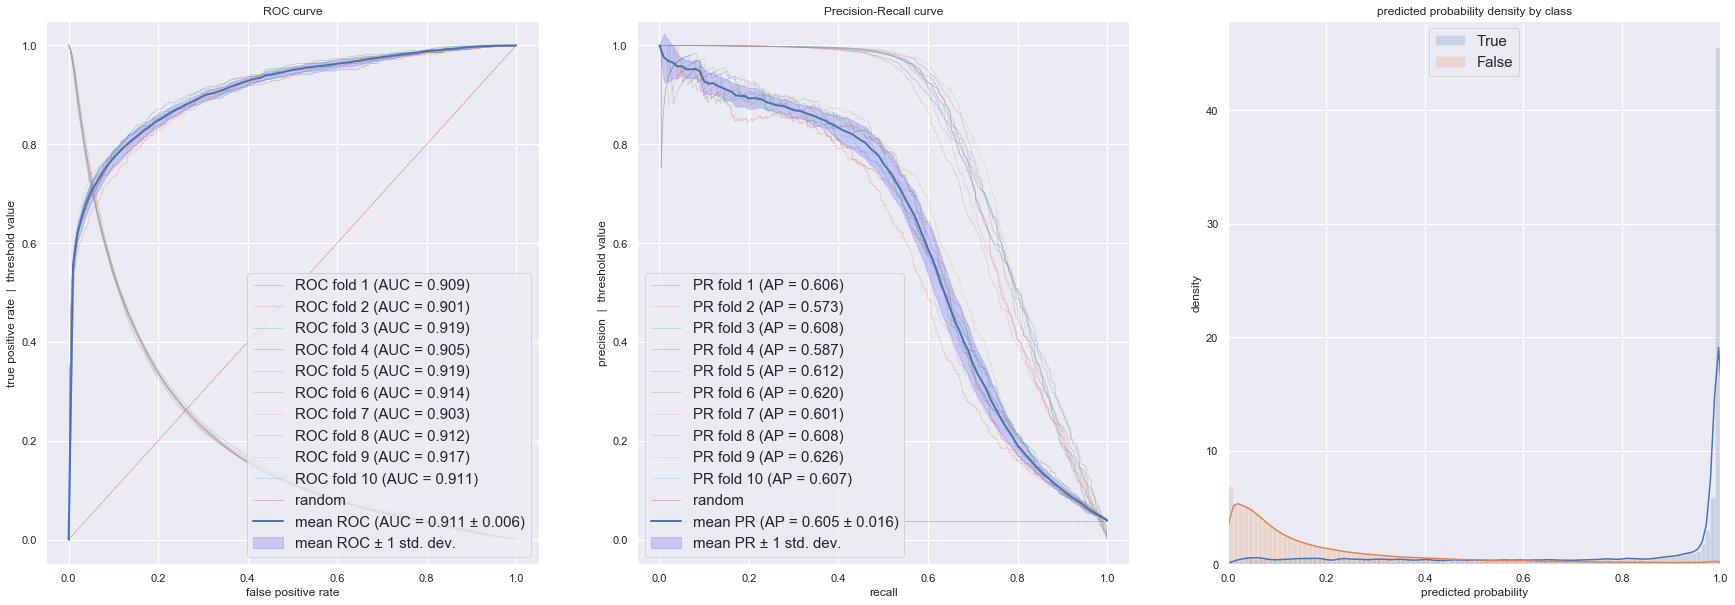

In [50]:
metrics_all.plot_threshold_decision_curves()

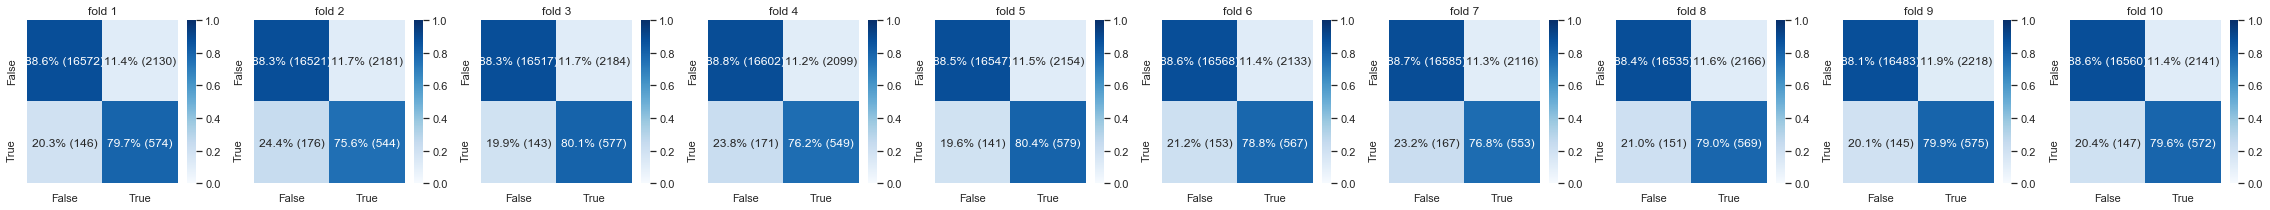

In [51]:
metrics_all.plot_confusion_matrix(figsize=(40, 3))

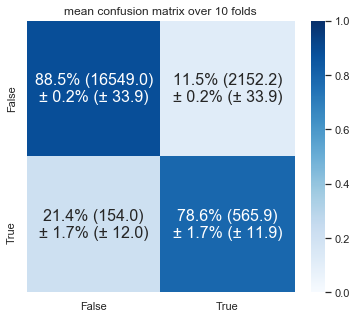

In [52]:
metrics_all.plot_mean_confusion_matrix(figsize=(6, 5), legend_size=16)

## Evaluation by groups

In [11]:
metrics_list = {}

for group in features_groups.keys():
    print_md('**Withoug *{}* group** ({} features)'.format(group, len(features)))
    features = get_features(groups_to_remove = [group], individual_features_to_remove = AF_populations + ['VEP_SYMBOL'])
    
    print('Get X and y...', end= '')
    start = time.time()
    data.process(features)
    X, y = data.get_X_and_y('all', 'all')
    print(' done! ({:.2f}s, {} features after processing)'.format(time.time() - start, X.shape[1]))
    
    metrics_list['without {}'.format(group)] = Metrics(model, X, y, cv_strategy, n_jobs=5, scoring=['accuracy', 'f1', 'roc_auc', 'average_precision', 'recall'])

**Withoug *NGS* group** (29 features)

Get X and y... done! (8.05s, 73 features after processing)
Run model... done! (182.52s)


**Withoug *genome* group** (18 features)

Get X and y... done! (6.21s, 52 features after processing)
Run model... done! (162.42s)


**Withoug *freq* group** (26 features)

Get X and y... done! (8.25s, 83 features after processing)
Run model... done! (252.88s)


**Withoug *database* group** (28 features)

Get X and y... done! (5.65s, 71 features after processing)
Run model... done! (216.33s)


**Withoug *consequence* group** (24 features)

Get X and y... done! (4.99s, 61 features after processing)
Run model... done! (188.13s)


**Withoug *AF* group** (24 features)

Get X and y... done! (8.13s, 80 features after processing)
Run model... done! (261.30s)


In [53]:
summary = Summary()

In [54]:
for key, color in zip(metrics_list, ['maroon', 'firebrick', 'crimson', 'tomato', 'coral', 'lightcoral']):
    summary.add(metrics_list[key], key, color)

summary.add(metrics_all, 'all', 'indigo')

,test_accuracy_mean,test_f1_mean,test_roc_auc_mean,test_average_precision_mean
metrics_name,,,,
only NGS,0.955,0.235,0.722,0.189
only genome,0.646,0.106,0.639,0.0632
only freq,0.962,0.329,0.622,0.207
only database,0.176,0.0799,0.716,0.0857
only consequence,0.892,0.211,0.742,0.141
only AF,0.971,0.456,0.764,0.405
all,0.881,0.329,0.911,0.605


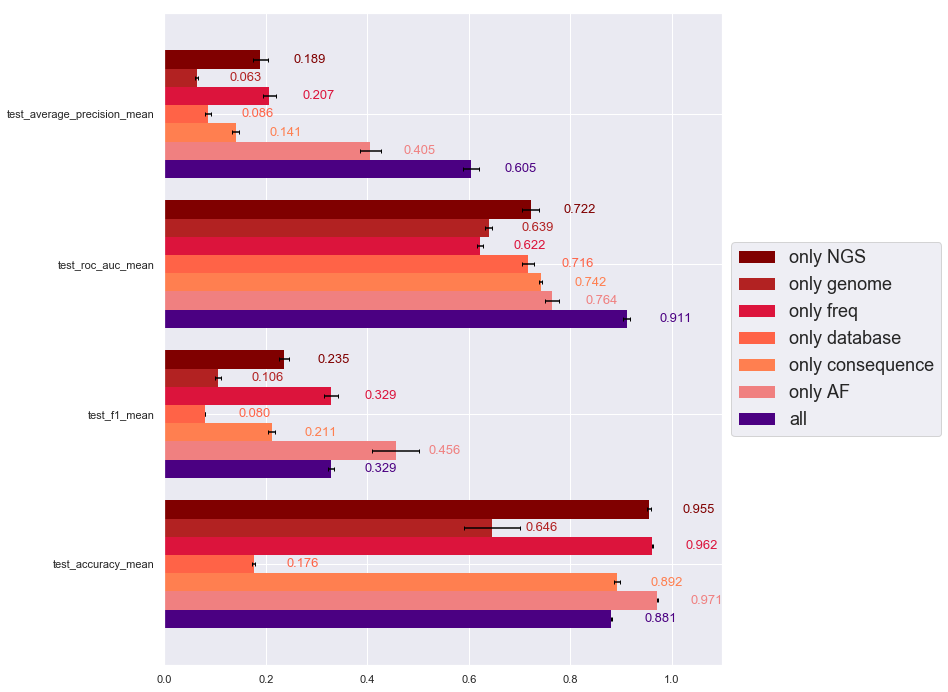

In [55]:
summary.display()
summary.plot()

## Evaluation with only one group

In [106]:
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
model = make_pipeline(RandomUnderSampler(ratio='majority', random_state=42),
                      StandardScaler(),
                      GaussianNB())

In [16]:
metrics_list = {}

for group in features_groups.keys():
    print_md('**Only *{}* group**'.format(group))
    features = get_features(groups_to_remove = [g for g in features_groups.keys() if g != group], individual_features_to_remove = AF_populations + ['VEP_SYMBOL'])
    
    print('Get X and y...', end= '')
    start = time.time()
    data.process(features)
    X, y = data.get_X_and_y('all', 'all')
    print(' done! ({:.2f}s, {} raw features, {} features after processing)'.format(time.time() - start, len(features), X.shape[1]))
    
    metrics_list['only {}'.format(group)] = Metrics(model, X, y, cv_strategy, n_jobs=5, scoring=['accuracy', 'f1', 'roc_auc', 'average_precision', 'recall'])

**Only *NGS* group**

Get X and y... done! (0.48s, 11 raw features, 11 features after processing)
Run model... done! (2.15s)


**Only *genome* group**

Get X and y... done! (2.53s, 3 raw features, 32 features after processing)
Run model... done! (9.59s)


**Only *freq* group**

Get X and y... done! (0.43s, 1 raw features, 1 features after processing)
Run model... done! (1.02s)


**Only *database* group**

Get X and y... done! (3.30s, 5 raw features, 13 features after processing)
Run model... done! (6.98s)


**Only *consequence* group**

Get X and y... done! (3.81s, 5 raw features, 23 features after processing)
Run model... done! (9.81s)


**Only *AF* group**

Get X and y... done! (0.38s, 4 raw features, 4 features after processing)
Run model... done! (1.32s)


In [30]:
%run ../summary.py

<Figure size 432x288 with 0 Axes>

In [56]:
summary = Summary()

In [57]:
for key, color in zip(metrics_list, ['maroon', 'firebrick', 'crimson', 'tomato', 'coral', 'lightcoral']):
    summary.add(metrics_list[key], key, color)

summary.add(metrics_all, 'all', 'indigo')

,test_accuracy_mean,test_f1_mean,test_roc_auc_mean,test_average_precision_mean
metrics_name,,,,
only NGS,0.955,0.235,0.722,0.189
only genome,0.646,0.106,0.639,0.0632
only freq,0.962,0.329,0.622,0.207
only database,0.176,0.0799,0.716,0.0857
only consequence,0.892,0.211,0.742,0.141
only AF,0.971,0.456,0.764,0.405
all,0.881,0.329,0.911,0.605


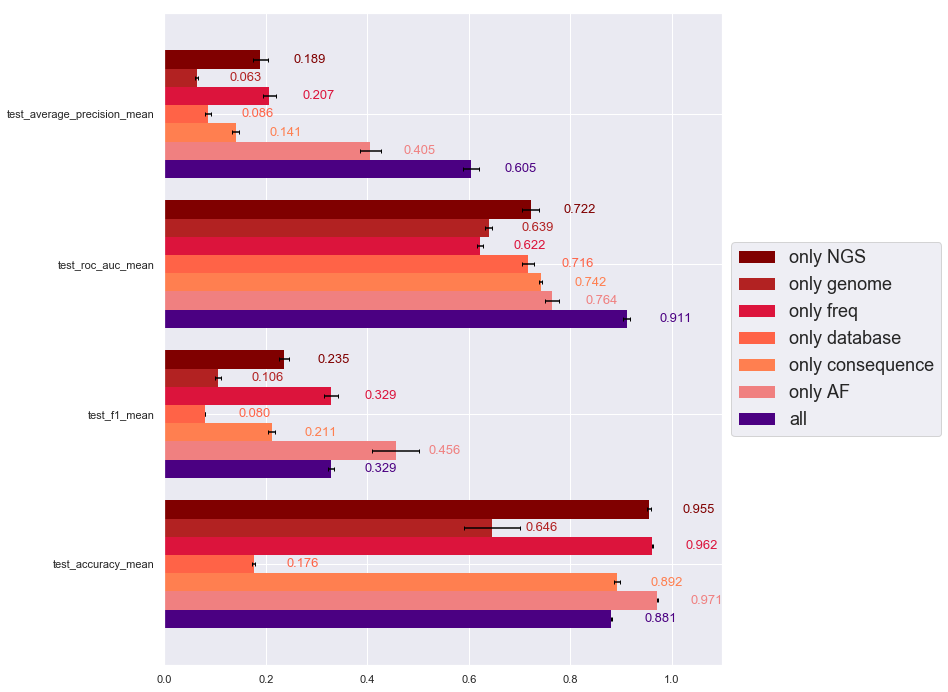

In [58]:
summary.display()
summary.plot()

In [102]:
%run ../summary.py

summary = Summary()

for key, color in zip(metrics_list, ['maroon', 'firebrick', 'crimson', 'tomato', 'coral', 'lightcoral']):
    summary.add(metrics_list[key], key, color)

summary.add(metrics_all, 'all', 'indigo')

<Figure size 432x288 with 0 Axes>

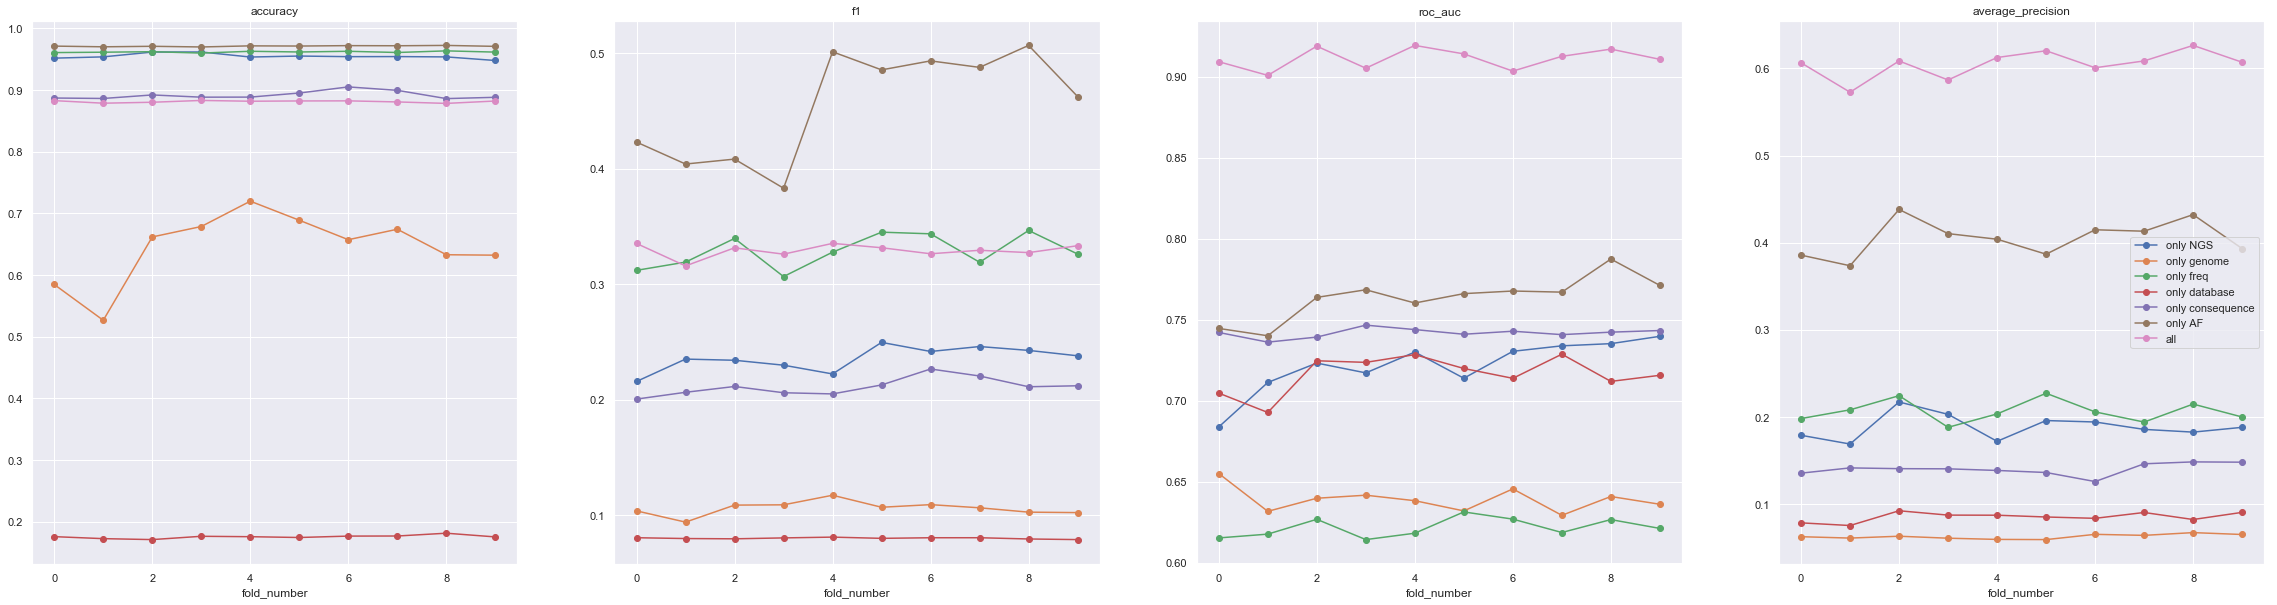

In [103]:
summary.plot_cv_curves()

## Without gnomAD populations

In [104]:
summary = Summary()

In [107]:
features = get_features(individual_features_to_remove = ['VEP_SYMBOL'])
data.process(features)
X, y = data.get_X_and_y('all', 'all')

metrics = Metrics(model, X, y, cv_strategy, n_jobs=5, scoring=['accuracy', 'f1', 'roc_auc', 'average_precision', 'recall'])
summary.add(metrics, 'with', 'firebrick')

Run model... done! (30.49s)


In [108]:
features = get_features(individual_features_to_remove = AF_populations + ['VEP_SYMBOL'])
data.process(features)
X, y = data.get_X_and_y('all', 'all')

metrics = Metrics(model, X, y, cv_strategy, n_jobs=5, scoring=['accuracy', 'f1', 'roc_auc', 'average_precision', 'recall'])
summary.add(metrics, 'without', 'crimson')

Run model... done! (26.74s)


,test_accuracy_mean,test_f1_mean,test_roc_auc_mean,test_average_precision_mean
metrics_name,,,,
with,0.96,0.472,0.821,0.319
without,0.947,0.423,0.817,0.293


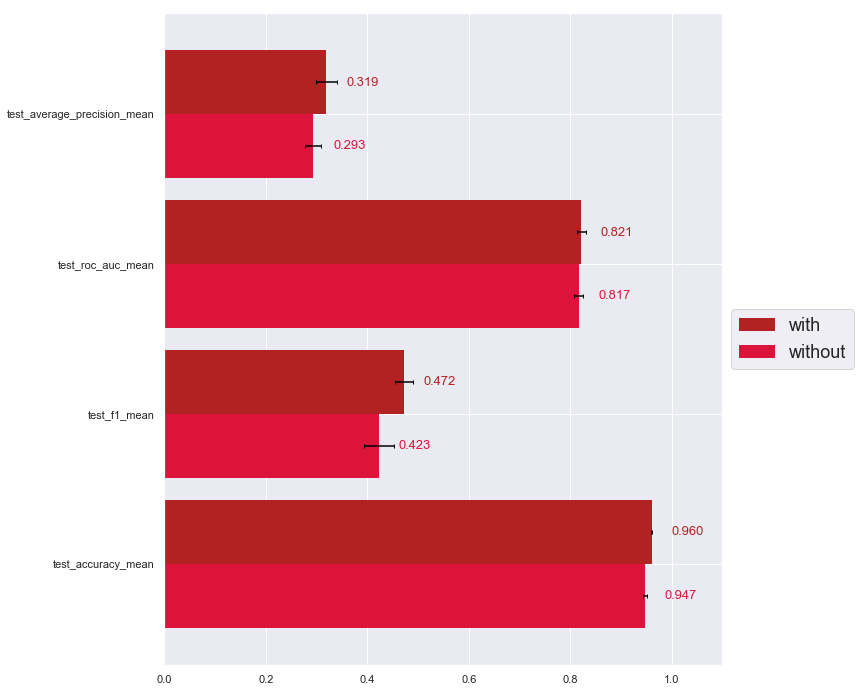

In [109]:
summary.display()
summary.plot()

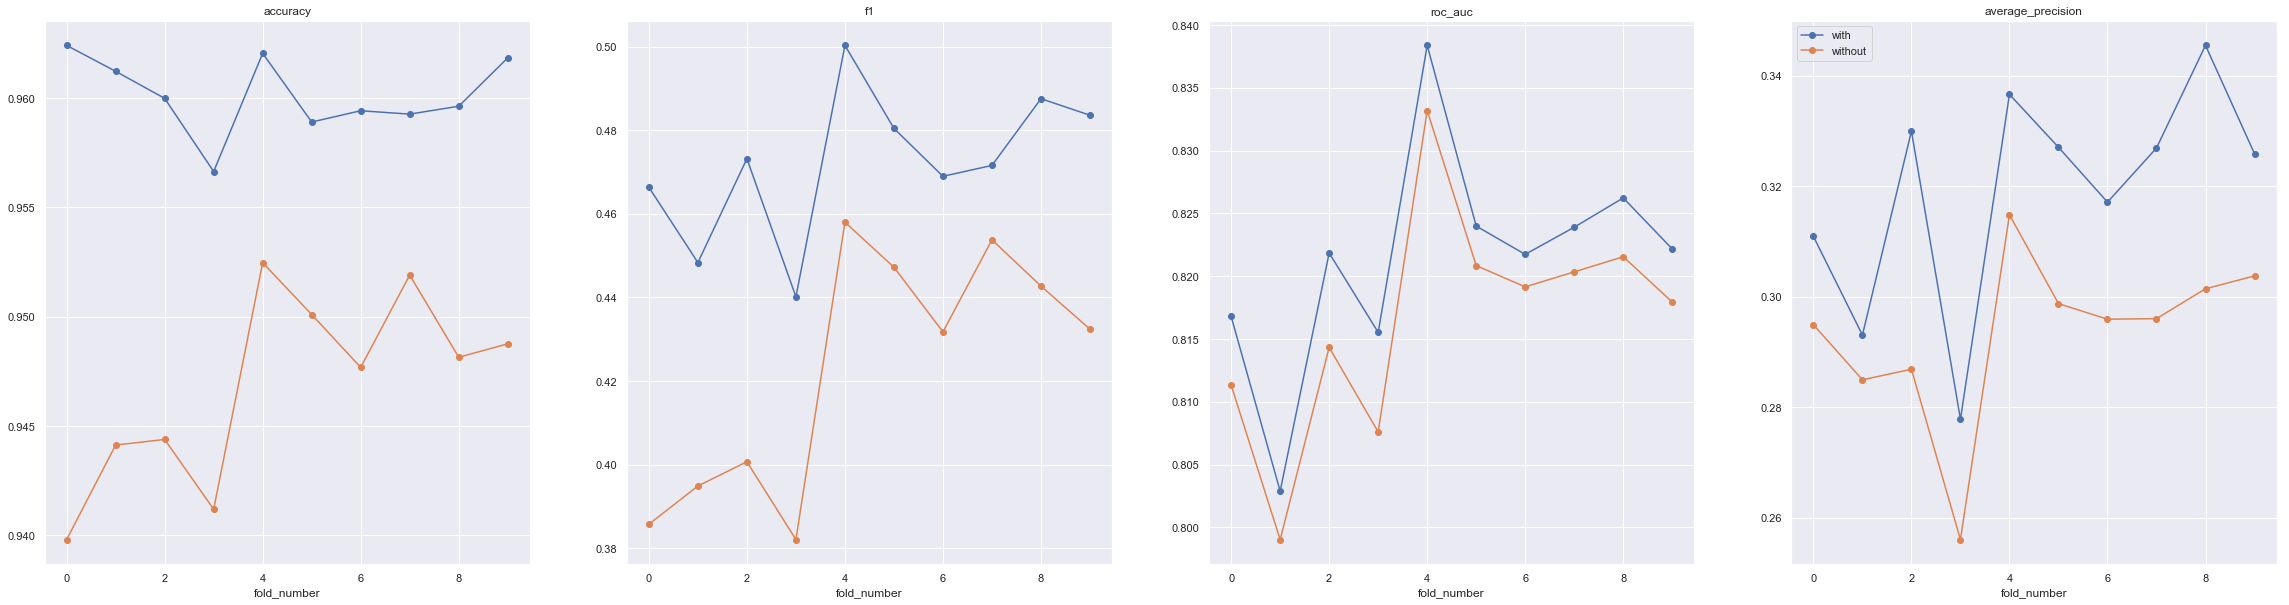

In [110]:
summary.plot_cv_curves()